In [20]:
import h5py
import json
import os
import re

from ASF import ASF, Hyperparams
import result_types


def folder_name():
    return "/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/"

class ResultsLoader:
    def __init__(self):
        self.file = folder_name() + "master.hdf5"
        self.file_handle = None
        print(self.file)

    def __enter__(self):
        if not os.path.exists(folder_name()):
            Warning("No results found.")
            return self
        worker_files = [file for file in os.listdir(folder_name()) 
                        if re.match("rank_.*.hdf5",  file)]
        if not worker_files:
            return self
        self.file_handle = h5py.File(self.file, "w")
        for file in worker_files:
            self.file_handle[file] = h5py.ExternalLink(folder_name()+file, "/")
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self.file_handle is not None and self.file_handle:
            print("closing from __exit__")
            self.file_handle.close()

    def __del__(self):
        if self.file_handle is not None and self.file_handle:
            print("closing from __del__")

            self.file_handle.close()

    # Returns a generator of all calculated results as a tuple 
    #  (ASF, ConvergedResult, lambda())
    def get_all_runs(self):
        if self.file_handle is None:
            return
        for key, file in self.file_handle.items():
            hyperparams = Hyperparams(**json.loads(file["hyperparams"][()]))
            for convergence_type, con_group in file.items():
                if convergence_type == "hyperparams":
                    continue
                type = getattr(result_types, convergence_type)
                for run in con_group.values():
                    asf = ASF(**json.loads(run.attrs["asf"]), hyperparams=hyperparams)
                    yield asf, type, lambda run=run, hyperparams=hyperparams, type=type, filter=None,: ResultsLoader.deserialize_result(run, hyperparams, type, filter)
                    # yield asf, type, lambda filter=None: ResultsLoader.deserialize_result(run, hyperparams, type, filter)

    @staticmethod
    def deserialize_result(group, hyperparams, type, filter):
        fields = {}
        for key, val in group.items():
            if filter is not None and key not in filter:
                continue
            val = val[()]
            if type(val) == bytes:
                val = val.decode("utf-8")
            if key == "initial_asf":
                if val == b"[None]":
                    fields[key] = None
                else:
                    fields[key] = ASF(**json.loads(val), hyperparams=hyperparams)
            else:
                fields[key] = val
        return type(**fields)

def explore_selected_groups(file_handle, num_groups=3):
    """
    Explore a few groups (worker files) and their contents, handling scalar datasets properly.
    
    Parameters:
    - file_handle: The HDF5 file handle
    - num_groups: Number of groups (worker files) to explore
    """
    group_count = 0
    
    for key in file_handle.keys():
        if group_count >= num_groups:
            break

        group = file_handle[key]
        
        if isinstance(group, h5py.Group):
            print(f"\nExploring group: {key}")
            print(f"Contains {len(group.keys())} items")

            # Explore sub-items in the group
            for sub_key, item in group.items():
                if isinstance(item, h5py.Group):
                    print(f"  {sub_key} is a sub-group with {len(item)} items")
                elif isinstance(item, h5py.Dataset):
                    print(f"  {sub_key} is a dataset - shape: {item.shape}, dtype: {item.dtype}")
                    
                    # Handle scalar datasets
                    if item.shape == ():  # This means it's a scalar dataset
                        print(f"    Scalar value: {item[()]}")
                    else:
                        # Print a small sample of the dataset for non-scalar datasets
                        print(f"    Data sample: {item[()][:10] if len(item) >= 10 else item[()]}")
        
        group_count += 1





def recursive_explore_group(group, level=0):
    """
    Recursively explores the contents of a group, including sub-groups.
    
    Parameters:
    - group: The HDF5 group to explore
    - level: Current recursion depth for formatting output
    """
    indent = "  " * level
    
    for sub_key, item in group.items():
        if isinstance(item, h5py.Group):
            print(f"{indent}{sub_key} is a sub-group with {len(item)} items")
            recursive_explore_group(item, level + 1)
        elif isinstance(item, h5py.Dataset):
            print(f"{indent}{sub_key} is a dataset - shape: {item.shape}, dtype: {item.dtype}")
            # Handle scalar datasets
            if item.shape == ():  # This means it's a scalar dataset
                print(f"    Scalar value: {item[()]}")
            else:
                # Print a small sample of the dataset for non-scalar datasets
                print(f"    Data sample: {item[()][:10] if len(item) >= 10 else item[()]}")

def explore_selected_groups_recursive(file_handle, num_groups=3):
    """
    Explore a few groups (worker files) and their contents recursively.
    
    Parameters:
    - file_handle: The HDF5 file handle
    - num_groups: Number of groups (worker files) to explore
    """
    group_count = 0
    
    for key in file_handle.keys():
        if group_count >= num_groups:
            break

        group = file_handle[key]
        
        if isinstance(group, h5py.Group):
            print(f"\nExploring group: {key}")
            recursive_explore_group(group)

        group_count += 1

# Explore a few groups recursively
with ResultsLoader() as loader:
    explore_selected_groups_recursive(loader.file_handle, num_groups=3)

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5

Exploring group: rank_Worker-01368c75-426f-4e90-9d41-70f54af0fc75.hdf5
ConvergedResult is a sub-group with 54 items
  00aa0d45f59709ff29bb1ef08c62c75eeb418c7e702e6ff2508364e9d35a6870a2f9f048748e7a2d3ca9baeb7681de68f9ad14f1df146c0bf11beea965d46e14_961119ac8037c1e9bd2849640b0e96f62ad4ffc6bea4a74f7a83ab57e0d233c37315810a24dcdf1eb4561e33eb5b9a58f216365730e0c6123e4da864b9c21471 is a sub-group with 5 items
    eigenvalues is a dataset - shape: (243,), dtype: float64
    Data sample: [-792.35350228 -792.34447274 -789.98413868 -789.98412043 -789.37827778
 -789.37799281 -789.37749223 -789.37661805 -789.35592623 -789.35069264]
    eigenvectors is a dataset - shape: (243, 243), dtype: float64
    Data sample: [[ 0.          0.          0.         ... -0.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.          0.
   0.        ]
 ...

In [18]:
# Explore only a few groups (e.g., the first 3 worker groups)
with ResultsLoader() as loader:
    explore_selected_groups(loader.file_handle, num_groups=100)

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5

Exploring group: rank_Worker-01368c75-426f-4e90-9d41-70f54af0fc75.hdf5
Contains 3 items
  ConvergedResult is a sub-group with 54 items
  NonConvergedResult is a sub-group with 60 items
  hyperparams is a dataset - shape: (), dtype: object
    Scalar value: b'{"orbitals": [[1, 0], [2, 0], [2, 1], [3, 0], [3, 1], [3, 2], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2]], "num_excitations": 2, "max_excitation": 6}'

Exploring group: rank_Worker-0184ecfb-b5d8-489b-8b9d-088741b07712.hdf5
Contains 3 items
  ConvergedResult is a sub-group with 47 items
  NonConvergedResult is a sub-group with 63 items
  hyperparams is a dataset - shape: (), dtype: object
    Scalar value: b'{"orbitals": [[1, 0], [2, 0], [2, 1], [3, 0], [3, 1], [3, 2], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2]], "num_excitations": 2, "max_excitation": 6}'

Exploring group: rank

In [22]:
with ResultsLoader() as loader:
    for asf, result_type, getter in loader.get_all_runs():
        print(asf.num_protons, asf.num_electrons)



/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
16 13
15 14
25 22
14 11
7 7
3 3
14 13
43 40
38 35
7 5
19 16
5 4
41 39
20 18
19 17
21 19
7 7
30 27
9 9
10 10
8 8
18 16
15 15
12 10
19 17
13 10
17 16
12 10
10 10
23 21
12 9
13 13
8 6
11 9
5 4
41 39
10 10
18 15
23 21
16 15
17 17
16 14
20 19
20 19
11 9
16 15
16 16
12 10
10 10
14 11
39 36
15 13
8 6
23 20
22 21
40 39
7 6
25 23
18 18
31 29
21 21
32 30
22 22
36 33
44 44
26 25
43 42
30 28
27 26
18 15
10 9
5 4
8 7
8 7
12 12
5 4
45 44
7 6
24 23
37 34
23 20
14 12
29 29
11 10
9 7
37 35
24 23
20 17
13 11
31 28
36 35
24 23
11 9
8 7
29 29
33 30
10 9
34 31
40 39
29 28
25 23
12 12
25 23
35 34
13 11
40 40
6 5
20 20
9 9
36 36
13 12
13 12
4 3
29 28
29 29
16 13
8 8
17 15
5 5
29 28
39 37
19 18
21 18
5 4
11 8
40 38
41 39
14 13
6 5
24 21
21 19
16 13
17 14
14 13
12 10
24 21
16 14
16 15
30 29
39 36
11 8
43 42
19 17
10 10
20 18
17 14
7 7
30 29
18 18
16 15
21 18
20 18
14 13
21 19
19 17
15 14
14 13
10 7
32 30
43 40
12 9
41 40
8 7
32 29
41 39
23 22


KeyboardInterrupt: 

In [2]:
import pandas as pd

In [35]:
climate = pd.read_excel("/Users/moustholmes/Downloads/climate.xlsx")

/Users/moustholmes/miniconda3/envs/metal-ai/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [36]:
climate.loc[climate['station'] == 'oxford']

,station,year,month,af,rain,sun,device
36,oxford,2016,1,5,83.9,59.1,Campbell Stokes
37,oxford,2016,2,6,47.6,112.9,Campbell Stokes
38,oxford,2016,3,4,74.2,123.8,Campbell Stokes
39,oxford,2016,4,1,53.1,163.7,Campbell Stokes
40,oxford,2016,5,0,86.1,202.9,Campbell Stokes
41,oxford,2016,6,0,95.7,100.4,Campbell Stokes
42,oxford,2016,7,0,3.4,227.6,Campbell Stokes
43,oxford,2016,8,0,41.2,204.5,Campbell Stokes
44,oxford,2016,9,0,44.6,113.2,Campbell Stokes
45,oxford,2016,10,0,26.5,112.2,Campbell Stokes


In [34]:
# climate['rain'] = climate['rain']/10
climate


,station,year,month,af,rain,sun,device
0,armagh,2016,1,5,1.319,44.5,Campbell Stokes
1,armagh,2016,2,10,0.626,71.3,Campbell Stokes
2,armagh,2016,3,4,0.438,117.3,Campbell Stokes
3,armagh,2016,4,5,0.540,139.7,Campbell Stokes
4,armagh,2016,5,0,0.414,209.6,Campbell Stokes
5,armagh,2016,6,0,0.751,113.6,Campbell Stokes
6,armagh,2016,7,0,0.806,113.1,Campbell Stokes
7,armagh,2016,8,0,0.525,134.6,Campbell Stokes
8,armagh,2016,9,0,0.654,91.1,Campbell Stokes
9,armagh,2016,10,0,0.371,89.8,Campbell Stokes


In [37]:
climate.groupby('station').sum()

,year,month,af,rain,sun,device
station,,,,,,
armagh,24192,78,33,736.6,1250.6,Campbell StokesCampbell StokesCampbell StokesC...
camborne,24192,78,0,1147.3,1437.2,Kipp ZonenKipp ZonenKipp ZonenKipp ZonenKipp Z...
lerwick,24192,78,23,1217.9,1209.7,Kipp ZonenKipp ZonenKipp ZonenKipp ZonenKipp Z...
oxford,24192,78,29,658.2,1570.9,Campbell StokesCampbell StokesCampbell StokesC...
sheffield,24192,78,16,787.8,1360.7,Kipp ZonenKipp ZonenKipp ZonenKipp ZonenKipp Z...


In [38]:
# get the number of observations for each station
climate.groupby('station').count()

,year,month,af,rain,sun,device
station,,,,,,
armagh,12,12,12,12,12,12
camborne,12,12,12,12,12,12
lerwick,12,12,12,12,12,12
oxford,12,12,12,12,12,12
sheffield,12,12,12,12,12,12


In [39]:
climate.describe()

,year,month,af,rain,sun
count,60.0,60.000000,60.000000,60.000000,60.000000
mean,2016.0,6.500000,1.683333,75.796667,113.818333
std,0.0,3.481184,2.801281,43.189154,52.306993
min,2016.0,1.000000,0.000000,3.400000,11.500000
25%,2016.0,3.750000,0.000000,45.900000,74.600000
50%,2016.0,6.500000,0.000000,64.000000,109.400000
75%,2016.0,9.250000,3.000000,90.200000,155.325000
max,2016.0,12.000000,10.000000,221.600000,227.600000


In [40]:
# sort the rows by the 'rain' column in descending order
climate.sort_values('rain', ascending=False)

,station,year,month,af,rain,sun,device
12,camborne,2016,1,0,221.6,48.0,Kipp Zonen
24,lerwick,2016,1,7,187.0,34.6,Kipp Zonen
13,camborne,2016,2,0,161.6,64.1,Kipp Zonen
35,lerwick,2016,12,0,159.4,11.5,Kipp Zonen
20,camborne,2016,9,0,153.7,102.8,Kipp Zonen
22,camborne,2016,11,0,137.0,56.5,Kipp Zonen
34,lerwick,2016,11,1,133.4,48.0,Kipp Zonen
0,armagh,2016,1,5,131.9,44.5,Campbell Stokes
53,sheffield,2016,6,0,130.4,106.5,Kipp Zonen
25,lerwick,2016,2,10,119.6,86.5,Kipp Zonen


In [42]:
# sort the rows by monthly sunshine in ascending order
climate.sort_values('sun')

,station,year,month,af,rain,sun,device
35,lerwick,2016,12,0,159.4,11.5,Kipp Zonen
24,lerwick,2016,1,7,187.0,34.6,Kipp Zonen
48,sheffield,2016,1,3,84.8,40.3,Kipp Zonen
0,armagh,2016,1,5,131.9,44.5,Campbell Stokes
23,camborne,2016,12,0,58.4,47.3,Kipp Zonen
34,lerwick,2016,11,1,133.4,48.0,Kipp Zonen
12,camborne,2016,1,0,221.6,48.0,Kipp Zonen
11,armagh,2016,12,1,51.4,50.5,Campbell Stokes
22,camborne,2016,11,0,137.0,56.5,Kipp Zonen
59,sheffield,2016,12,3,31.8,57.9,Kipp Zonen


In [44]:
# 9. Identify the weather station for which the median number of monthly sunshine hours over the months April to September was largest.

climate.loc[climate['month'].isin([4, 5, 6, 7, 8, 9])].groupby('station')['sun'].median()#.idxmax()

station
armagh       124.1
camborne     166.0
lerwick      131.6
oxford       183.3
sheffield    159.7
Name: sun, dtype: float64

In [47]:
# For each weather station apart from the one in Armagh, compute the total rainfall and
# sunshine duration during the months with no days of air frost. Present the totals in
# centimeters and days, respectively.

#might not be in cm
climate.loc[climate['station'] != 'armagh'].loc[climate['af'] == 0].groupby('station')[['rain', 'sun']].sum()

,rain,sun
station,,
camborne,1147.3,1437.2
lerwick,643.6,799.8
oxford,297.5,960.8
sheffield,354.0,841.0


In [48]:
# 11. For each of the months in the year 2016:
# a. Count how many stations recorded at least two days of air frost or more than 95 mm rain.
# b. Compute the average number of sunshine hours for these stations (still for each month).

climate.loc[climate['year'] == 2016].loc[(climate['af'] >= 2) | (climate['rain'] > 95)].groupby('month').count()

,station,year,af,rain,sun,device
month,,,,,,
1,5,5,5,5,5,5
2,5,5,5,5,5,5
3,4,4,4,4,4,4
4,2,2,2,2,2,2
6,2,2,2,2,2,2
7,1,1,1,1,1,1
8,1,1,1,1,1,1
9,2,2,2,2,2,2
11,5,5,5,5,5,5


In [49]:
# b. Compute the average number of sunshine hours for these stations (still for each month).
climate.loc[climate['year'] == 2016].loc[(climate['af'] >= 2) | (climate['rain'] > 95)].groupby('month')['sun'].mean()

month
1      45.300
2      86.180
3     105.975
4     148.150
6     103.450
7      80.500
8      92.200
9     104.700
11     68.040
12     43.900
Name: sun, dtype: float64

In [51]:
result = climate.groupby('station').agg({
    'rain': ['mean', 'std'],
    'sun': ['mean', 'std']
})

result.columns = ['rain_avg', 'rain_sd', 'sun_avg', 'sun_sd']

result = result.reset_index()
result

,station,rain_avg,rain_sd,sun_avg,sun_sd
0,armagh,61.383333,26.116168,104.216667,45.091419
1,camborne,95.608333,59.425805,119.766667,55.798718
2,lerwick,101.491667,45.644505,100.808333,57.533112
3,oxford,54.850000,28.535321,130.908333,56.142100
4,sheffield,65.650000,30.456661,113.391667,49.230671


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='rain', ylabel='sun'>

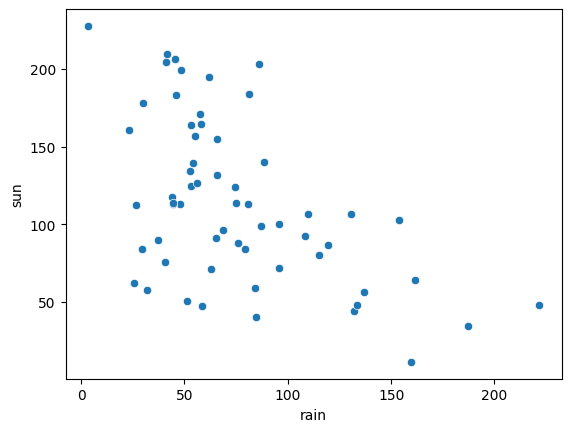

In [52]:


# 1. Make a scatter plot of rain against sun.

sns.scatterplot(data=climate, x='rain', y='sun')

<Axes: xlabel='rain', ylabel='sun'>

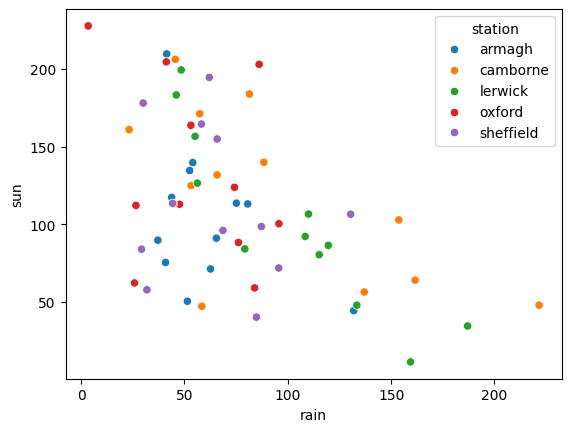

In [53]:
# Colour the points in the scatter plot according to weather station
sns.scatterplot(data=climate, x='rain', y='sun', hue='station')

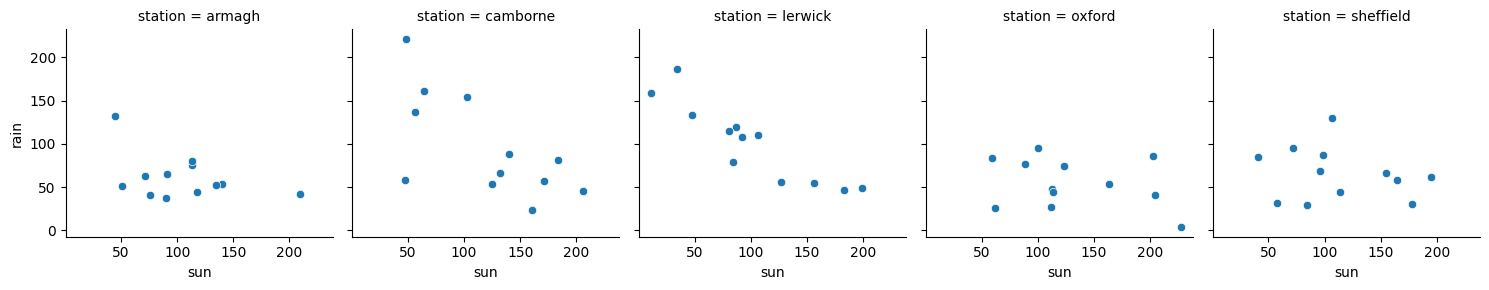

In [55]:
g = sns.FacetGrid(climate, col='station')
g.map(sns.scatterplot, 'sun', 'rain')

<Axes: xlabel='month', ylabel='rain'>

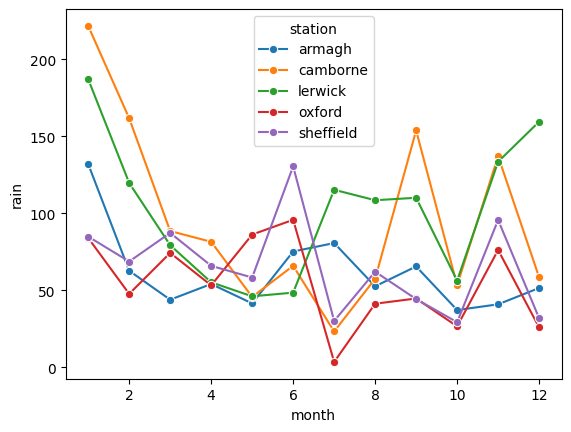

In [58]:
sns.lineplot(data=climate, x='month', y='rain', hue='station', marker="o")

<Axes: xlabel='station', ylabel='sun'>

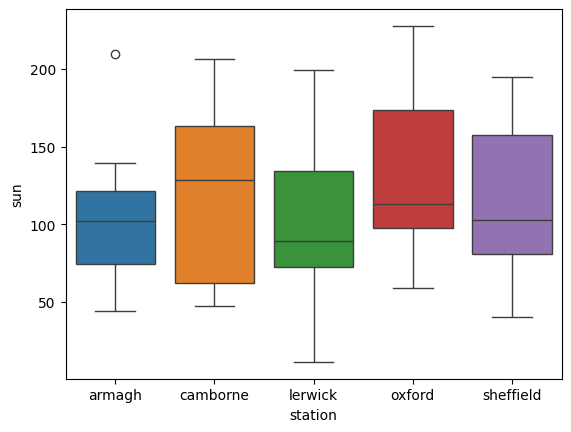

In [60]:
# 14. Make a box plot of the sunshine observations by weather station.

sns.boxplot(data=climate, x='station', y='sun', hue='station')

<Axes: xlabel='month', ylabel='sun'>

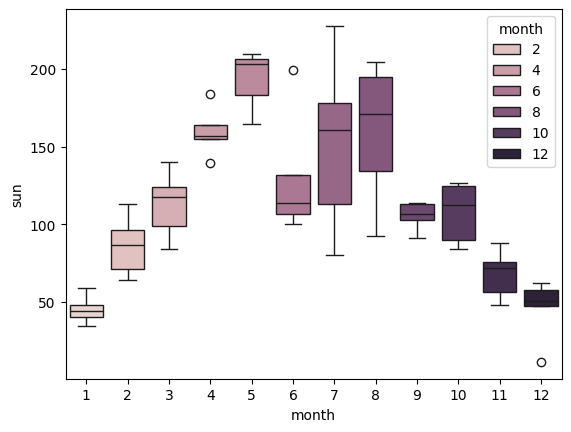

In [61]:
# Replace station by month in your code, possibly several places. Is the output as expected
# and as you would like it to be? 

sns.boxplot(data=climate, x='month', y='sun', hue='month')

In [63]:
result

,station,rain_avg,rain_sd,sun_avg,sun_sd
0,armagh,61.383333,26.116168,104.216667,45.091419
1,camborne,95.608333,59.425805,119.766667,55.798718
2,lerwick,101.491667,45.644505,100.808333,57.533112
3,oxford,54.850000,28.535321,130.908333,56.142100
4,sheffield,65.650000,30.456661,113.391667,49.230671


<Axes: xlabel='station', ylabel='rain'>

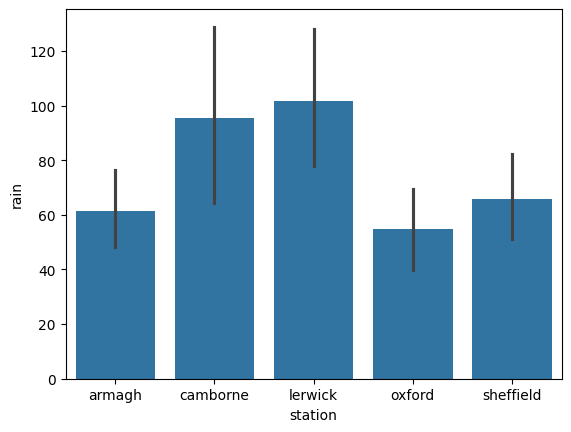

In [66]:
# Barplot
# Many papers include a bar plot with average values of the resoponse as bars and error bars
# with standard deviations or standard errors of means.

sns.barplot(data=climate, x='station', y='rain', estimator='mean')

<Axes: xlabel='month', ylabel='sun'>

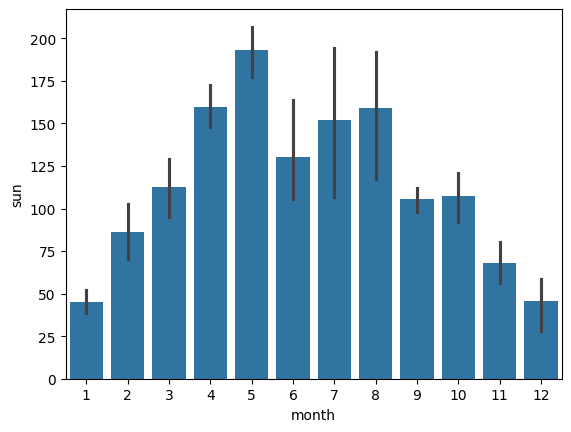

In [67]:
sns.barplot(data=climate, x='month', y='sun', estimator='mean')

<Axes: xlabel='month', ylabel='sun'>

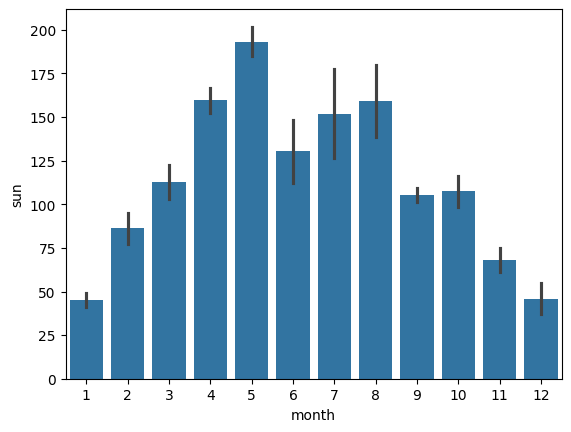

In [69]:
sns.barplot(data=climate, x='month', y='sun', estimator='mean', errorbar='se')


<Axes: xlabel='station', ylabel='rain'>

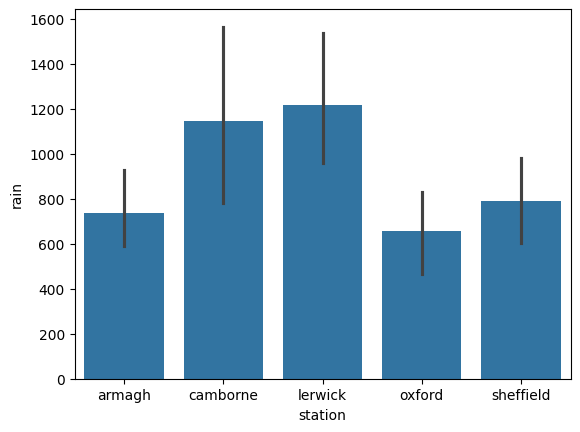

In [70]:
# Make a bar plot showing the annual rainfall recorded at each weather station.

sns.barplot(data=climate, x='station', y='rain', estimator='sum')

<Axes: xlabel='station', ylabel='rain'>

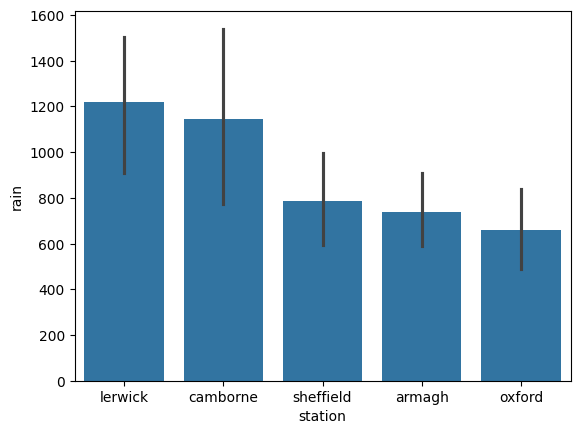

In [72]:
# Order the bars in the bar plot according to total annual rainfall.

sns.barplot(
    data=climate, x='station', y='rain', 
    estimator='sum',
    order=climate.groupby('station')['rain'].sum().sort_values(ascending=False).index
    )

# scatterplot II

<Axes: xlabel='month', ylabel='sun'>

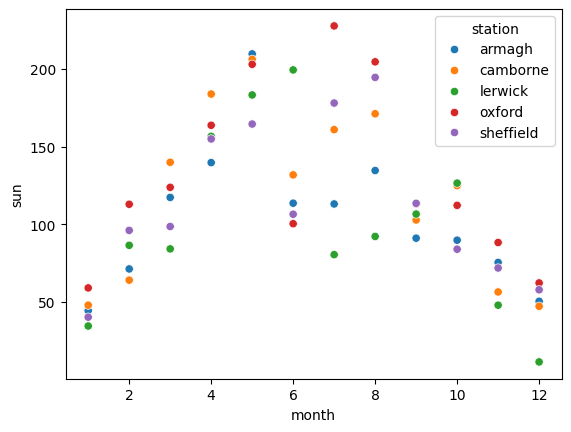

In [74]:
# Make a scatter plot with month on the x-axis, and the average number of sunshine hours
# on the y-axis.

sns.scatterplot(data=climate, x='month', y='sun', hue='station', )

<Axes: xlabel='month', ylabel='sun'>

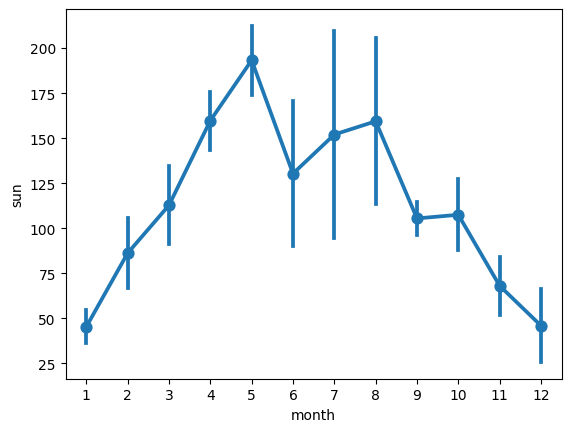

In [75]:
# Add error bars to the plot, which represent the average number of sunshine hours
# plus/minus the standard deviation of the observations.

sns.pointplot(data=climate, x='month', y='sun', errorbar='sd')


<ErrorbarContainer object of 3 artists>

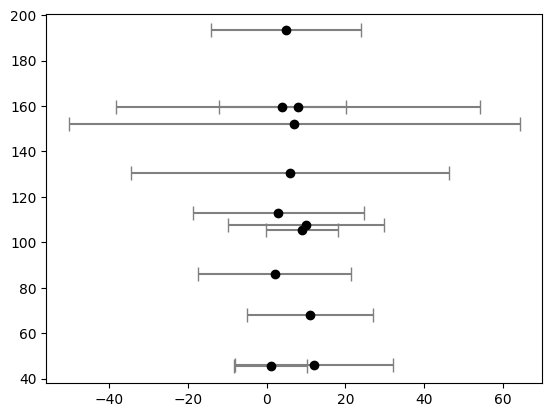

In [77]:
mean_sun = climate.groupby('month')['sun'].mean()
std_sun = climate.groupby('month')['sun'].std()

# Reset index to align with plot
mean_sun = mean_sun.reset_index()
std_sun = std_sun.reset_index()

# Create the pointplot
# ax = sns.pointplot(data=climate, x='month', y='sun', errorbar=None)  # Disable default error bars

plt.errorbar(mean_sun['month'], mean_sun['sun'], xerr=std_sun['sun'], fmt='o', color='black', ecolor='gray', capsize=5)


<Axes: xlabel='rain', ylabel='Count'>

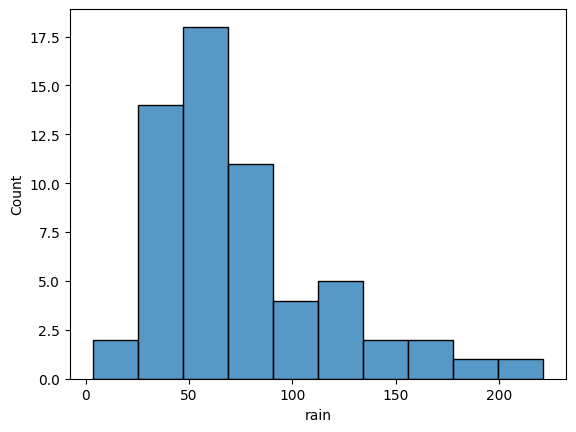

In [78]:
# histogram

sns.histplot(data=climate, x='rain')

# Part 4: Case study on meteorological data from Norway

In [ ]:
import plotly.express as px
import plotly.io as pio

# Set the default renderer to 'notebook' or 'notebook_connected'
pio.renderers.default = 'notebook'  # or 'notebook_connected'

In [19]:
snow_1970_1980 = pd.read_excel("/Users/moustholmes/Downloads/Snow_depth_Norway_1970_1980_OK.xlsx")
snow_1970_1980

,Snow_depth_(cm),Date_and_time,Station_number,Station_name,Latitude_(°N),Longitude_(°E),Elevation_(m)
0,52,1970-01-01,SN46460:0,RØLDAL KRAFTVERK,59.8222,6.8180,390
1,55,1970-01-02,SN46460:0,RØLDAL KRAFTVERK,59.8222,6.8180,390
2,58,1970-01-03,SN46460:0,RØLDAL KRAFTVERK,59.8222,6.8180,390
3,61,1970-01-04,SN46460:0,RØLDAL KRAFTVERK,59.8222,6.8180,390
4,60,1970-01-05,SN46460:0,RØLDAL KRAFTVERK,59.8222,6.8180,390
...,...,...,...,...,...,...,...
23522,14,1979-12-27,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20
23523,14,1979-12-28,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20
23524,14,1979-12-29,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20
23525,14,1979-12-30,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20


<Axes: xlabel='Date_and_time', ylabel='Snow_depth_(cm)'>

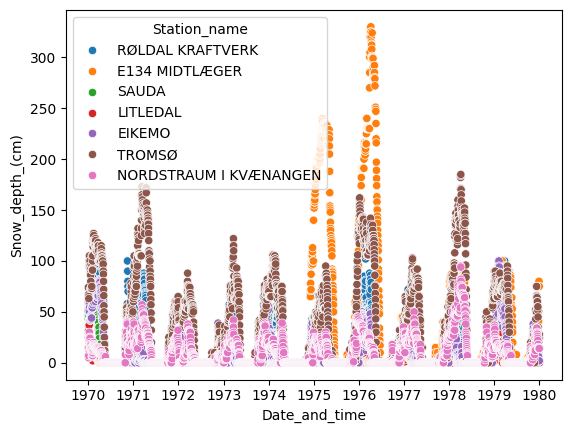

In [24]:
# 1. Make a scatter plot of snow depth against year.

sns.scatterplot(data=snow_1970_1980, x='Date_and_time', y='Snow_depth_(cm)', hue = 'Station_name')

In [28]:
# Make a subdataset which only contains datalines where snow depth is non-negative
snow_1970_1980_neg = snow_1970_1980.loc[snow_1970_1980['Snow_depth_(cm)'] < 0]
snow_1970_1980_neg

,Snow_depth_(cm),Date_and_time,Station_number,Station_name,Latitude_(°N),Longitude_(°E),Elevation_(m)


In [29]:
# Make a subdataset which only contains datalines where snow depth is non-negative
snow_2008_2018_neg = snow_2008_2018.loc[snow_2008_2018['Snow_depth_(cm)'] < 0]
snow_2008_2018_neg

,Snow_depth_(cm),Date_and_time,Station_number,Station_name,Latitude_(°N),Longitude_(°E),Elevation_(m)
32,-1,2008-02-01 11:00:00,SN46610:0,SAUDA,59.6479,6.3499,5.0
33,-1,2008-02-01 12:00:00,SN46610:0,SAUDA,59.6479,6.3499,5.0
34,-1,2008-02-01 13:00:00,SN46610:0,SAUDA,59.6479,6.3499,5.0
35,-1,2008-02-01 14:00:00,SN46610:0,SAUDA,59.6479,6.3499,5.0
36,-1,2008-02-01 15:00:00,SN46610:0,SAUDA,59.6479,6.3499,5.0
...,...,...,...,...,...,...,...
14785,-1,2016-10-27 06:00:00,SN90450:0,TROMSØ,69.6537,18.9368,100.0
14787,-1,2016-11-15 06:00:00,SN90450:0,TROMSØ,69.6537,18.9368,100.0
14789,-1,2016-11-16 06:00:00,SN90450:0,TROMSØ,69.6537,18.9368,100.0
14864,-1,2016-11-30 06:00:00,SN90450:0,TROMSØ,69.6537,18.9368,100.0


In [35]:
# Are there stations and days with more than one observation? Unfortunately, there is.
# Identify such a pair of measurements. What would be a reasonable solution if you only
# want a single measurement per station per day?

snow_2008_2018.groupby(['Station_name', 'Date_and_time']).count().sort_values('Snow_depth_(cm)', ascending=False)

Snow_depth_(cm)  Station_number  \
Station_name           Date_and_time                                    
TROMSØ                 2016-12-12                   2               2   
                       2016-12-05                   2               2   
SAUDA                  2008-02-05                   2               2   
TROMSØ                 2017-01-17                   2               2   
                       2016-12-28                   2               2   
...                                               ...             ...   
NORDSTRAUM I KVÆNANGEN 2009-01-23                   1               1   
                       2009-01-24                   1               1   
                       2009-01-25                   1               1   
                       2009-01-26                   1               1   
TROMSØ                 2018-09-14                   1               1   

                                      Latitude_(°N)  Longitude_(°E)  \
Station_name           Date_and_time                                  
TROMSØ                 2016-12-12                 2               2   
                       2016-12-05                 2               2   
SAUDA                  2008-02-05                 2               2   
TROMSØ                 2017-01-17                 2               2   
                       2016-12-28                 2               2   
...                                             ...             ...   
NORDSTRAUM I KVÆNANGEN 2009-01-23                 1               1   
                       2009-01-24                 1               1   
                       2009-01-25                 1               1   
                       2009-01-26                 1               1   
TROMSØ                 2018-09-14                 1               1   

                                      Elevation_(m)  
Station_name           Date_and_time                 
TROMSØ                 2016-12-12                 2  
                       2016-12-05                 2  
SAUDA                  2008-02-05                 2  
TROMSØ                 2017-01-17                 2  
                       2016-12-28                 2  
...                                             ...  
NORDSTRAUM I KVÆNANGEN 2009-01-23                 1  
                       2009-01-24                 1  
                       2009-01-25                 1  
                       2009-01-26                 1  
TROMSØ                 2018-09-14                 1  

[17421 rows x 5 columns]

In [39]:
# Station_name	Date_and_time					
# TROMSØ	2016-12-12	

# use .loc to find this data and station
snow_2008_2018.loc[(snow_2008_2018['Station_name'] == 'TROMSØ') & (snow_2008_2018['Date_and_time'] == '2016-12-12')]

,Snow_depth_(cm),Date_and_time,Station_number,Station_name,Latitude_(°N),Longitude_(°E),Elevation_(m)
15125,46,2016-12-12,SN90450:0,TROMSØ,69.6537,18.9368,100.0
15126,48,2016-12-12,SN90450:0,TROMSØ,69.6537,18.9368,100.0


In [40]:
# merge stations and days with more than one observation by taking mean of the snow depth


snow_2008_2018_cleaned = snow_2008_2018.groupby(['Station_name', 'Date_and_time'])[['Snow_depth_(cm)','Latitude_(°N)','Longitude_(°E)','Elevation_(m)']].mean().reset_index()

# remove the negative snow depth values
snow_2008_2018_cleaned = snow_2008_2018_cleaned.loc[snow_2008_2018_cleaned['Snow_depth_(cm)'] >= 0]
snow_2008_2018_cleaned

,Station_name,Date_and_time,Snow_depth_(cm),Latitude_(°N),Longitude_(°E),Elevation_(m)
0,EIKEMO,2008-01-01,1.0,59.8594,6.2786,178.0
1,EIKEMO,2008-01-02,1.0,59.8594,6.2786,178.0
2,EIKEMO,2008-01-03,0.0,59.8594,6.2786,178.0
3,EIKEMO,2008-01-07,1.0,59.8594,6.2786,178.0
4,EIKEMO,2008-01-08,1.0,59.8594,6.2786,178.0
...,...,...,...,...,...,...
17416,TROMSØ,2018-09-10,0.0,69.6537,18.9368,100.0
17417,TROMSØ,2018-09-11,0.0,69.6537,18.9368,100.0
17418,TROMSØ,2018-09-12,0.0,69.6537,18.9368,100.0
17419,TROMSØ,2018-09-13,0.0,69.6537,18.9368,100.0


In [42]:
# merge snow_2008_2018_cleaned and snow_1970_1980 by concatenating them
snow_all = pd.concat([snow_2008_2018_cleaned, snow_1970_1980])

snow_all

,Station_name,Date_and_time,Snow_depth_(cm),Latitude_(°N),Longitude_(°E),Elevation_(m),Station_number
0,EIKEMO,2008-01-01,1.0,59.8594,6.2786,178.0,NaN
1,EIKEMO,2008-01-02,1.0,59.8594,6.2786,178.0,NaN
2,EIKEMO,2008-01-03,0.0,59.8594,6.2786,178.0,NaN
3,EIKEMO,2008-01-07,1.0,59.8594,6.2786,178.0,NaN
4,EIKEMO,2008-01-08,1.0,59.8594,6.2786,178.0,NaN
...,...,...,...,...,...,...,...
23522,NORDSTRAUM I KVÆNANGEN,1979-12-27,14.0,69.8362,21.8958,20.0,SN92350:0
23523,NORDSTRAUM I KVÆNANGEN,1979-12-28,14.0,69.8362,21.8958,20.0,SN92350:0
23524,NORDSTRAUM I KVÆNANGEN,1979-12-29,14.0,69.8362,21.8958,20.0,SN92350:0
23525,NORDSTRAUM I KVÆNANGEN,1979-12-30,14.0,69.8362,21.8958,20.0,SN92350:0


In [20]:
snow_2008_2018 = pd.read_excel("/Users/moustholmes/Downloads/Snow_depth_Norway_2008_2018_OK.xlsx")
snow_2008_2018

,Snow_depth_(cm),Date_and_time,Station_number,Station_name,Latitude_(°N),Longitude_(°E),Elevation_(m)
0,0,2008-01-01,SN46610:0,SAUDA,59.6479,6.3499,NaN
1,0,2008-01-02,SN46610:0,SAUDA,59.6479,6.3499,5.0
2,0,2008-01-03,SN46610:0,SAUDA,59.6479,6.3499,5.0
3,0,2008-01-04,SN46610:0,SAUDA,59.6479,6.3499,5.0
4,0,2008-01-05,SN46610:0,SAUDA,59.6479,6.3499,5.0
...,...,...,...,...,...,...,...
17484,0,2018-09-26,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20.0
17485,0,2018-09-27,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20.0
17486,2,2018-09-28,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20.0
17487,0,2018-09-29,SN92350:0,NORDSTRAUM I KVÆNANGEN,69.8362,21.8958,20.0


In [44]:
snow_station_1970_1980 = Snow_depth_Norway_1970_1980_OK.groupby('Station_name')[
    ['Snow_depth_(cm)', 'Elevation_(m)','Latitude_(°N)','Longitude_(°E)']
    ].mean()
snow_station_1970_1980.reset_index()

,Station_name,Snow_depth_(cm),Elevation_(m),Latitude_(°N),Longitude_(°E)
0,E134 MIDTLÆGER,63.891022,1079.0,59.8402,6.9825
1,EIKEMO,7.562432,178.0,59.8594,6.2786
2,LITLEDAL,1.713308,83.0,59.6642,6.0657
3,NORDSTRAUM I KVÆNANGEN,9.957831,20.0,69.8362,21.8958
4,RØLDAL KRAFTVERK,16.400329,390.0,59.8222,6.8180
5,SAUDA,5.449890,5.0,59.6479,6.3499
6,TROMSØ,35.104053,100.0,69.6537,18.9368


In [46]:
fig = px.scatter_map(snow_station_1970_1980.reset_index(), lat="Latitude_(°N)", lon="Longitude_(°E)", hover_name="Station_name", hover_data=["Snow_depth_(cm)", "Elevation_(m)"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=600)
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [17]:
# calculate the average snow depth for each station
# and keep the latitude and longitude of the station

snow_station_2008_2018 = Snow_depth_Norway_2008_2018_OK.groupby('Station_name')[
    ['Snow_depth_(cm)', 'Elevation_(m)','Latitude_(°N)','Longitude_(°E)']
    ].mean()
snow_station_2008_2018

,Snow_depth_(cm),Elevation_(m),Latitude_(°N),Longitude_(°E)
Station_name,,,,
EIKEMO,9.696453,178.0,59.8594,6.2786
LITLEDAL,-0.406375,83.0,59.6642,6.0657
NORDSTRAUM I KVÆNANGEN,8.500966,20.0,69.8362,21.8958
SAUDA,3.327749,5.0,59.6479,6.3499
TROMSØ,31.857869,100.0,69.6537,18.9368


In [51]:
# get the average snow depth for each station for the years 1970-1980 in january
# groupe by station name and year 
snow_1970_1980_jan = Snow_depth_Norway_1970_1980_OK.loc[Snow_depth_Norway_1970_1980_OK['Date_and_time'].dt.month == 1]
snow_1970_1980_jan['Year'] = snow_1970_1980_jan['Date_and_time'].dt.year

# Group by both 'Station_name' and 'Year' and calculate the mean
snow_1970_1980_jan_avg = snow_1970_1980_jan.groupby(['Station_name', 'Year'])[
    ['Snow_depth_(cm)', 'Elevation_(m)', 'Latitude_(°N)', 'Longitude_(°E)']
].mean().reset_index()

snow_1970_1980_jan_avg

/var/folders/s2/8rc4lm651yq7h79nm3jxjzmm0000gn/T/ipykernel_39443/3624185907.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Station_name,Year,Snow_depth_(cm),Elevation_(m),Latitude_(°N),Longitude_(°E)
0,E134 MIDTLÆGER,1975,178.870968,1079.0,59.8402,6.9825
1,E134 MIDTLÆGER,1976,167.225806,1079.0,59.8402,6.9825
2,E134 MIDTLÆGER,1977,18.806452,1079.0,59.8402,6.9825
3,E134 MIDTLÆGER,1978,81.032258,1079.0,59.8402,6.9825
4,E134 MIDTLÆGER,1979,62.903226,1079.0,59.8402,6.9825
...,...,...,...,...,...,...
60,TROMSØ,1975,38.645161,100.0,69.6537,18.9368
61,TROMSØ,1976,137.806452,100.0,69.6537,18.9368
62,TROMSØ,1977,40.774194,100.0,69.6537,18.9368
63,TROMSØ,1978,64.354839,100.0,69.6537,18.9368


<Axes: xlabel='Year', ylabel='Snow_depth_(cm)'>

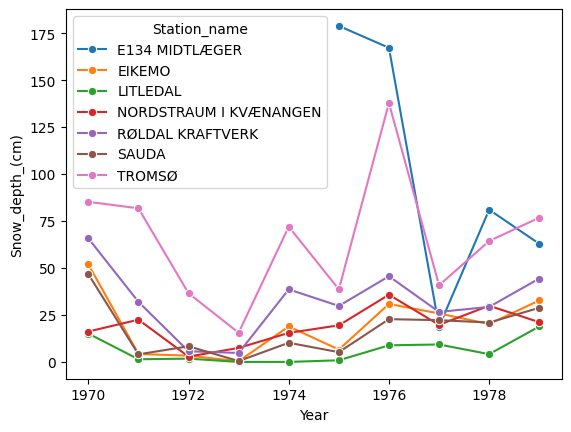

In [54]:
sns.lineplot(data=snow_1970_1980_jan_avg, x='Year', y='Snow_depth_(cm)', hue='Station_name', marker="o")

In [56]:
# Fit a linear regression with average snow depth in January as outcome and Year as
# covariate. What is the sign of the regression coefficients associated to Year, and what is
# the interpretation of the estimated coefficient?

import sklearn.linear_model as lm

# Reshape the 'Year' column to a 2D array
X = snow_1970_1980_jan_avg['Year'].values.reshape(-1, 1)
y = snow_1970_1980_jan_avg['Snow_depth_(cm)']

# Fit the linear regression model
model = lm.LinearRegression()
model.fit(X, y)

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient for Year: {model.coef_[0]}")

Intercept: -3432.0285581481826
Coefficient for Year: 1.7543367109788977


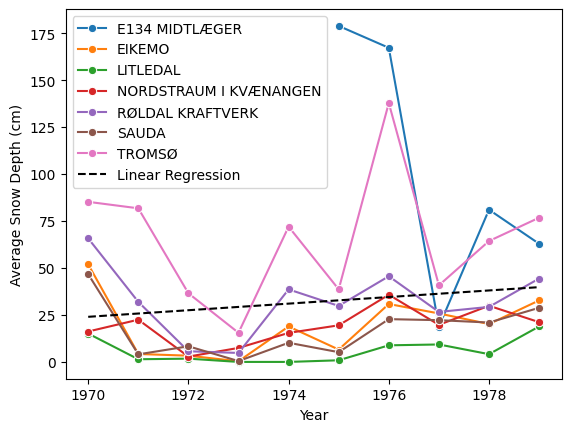

In [57]:

# Reshape the 'Year' column to a 2D array for fitting
X = snow_1970_1980_jan_avg['Year'].values.reshape(-1, 1)
y = snow_1970_1980_jan_avg['Snow_depth_(cm)']

# Fit the linear regression model
model = lm.LinearRegression()
model.fit(X, y)

# Generate predictions for the regression line
years = np.linspace(snow_1970_1980_jan_avg['Year'].min(), snow_1970_1980_jan_avg['Year'].max(), 100).reshape(-1, 1)
predictions = model.predict(years)

# Plot the original line plot with seaborn
sns.lineplot(data=snow_1970_1980_jan_avg, x='Year', y='Snow_depth_(cm)', hue='Station_name', marker="o")

# Plot the regression line on top
plt.plot(years, predictions, color='black', linestyle='--', label="Linear Regression")

# Add labels and legend
plt.xlabel("Year")
plt.ylabel("Average Snow Depth (cm)")
plt.legend()
plt.show()


In [58]:
# get the average snow depth for each station for the years 1970-1980 in january
# groupe by station name and year 
snow_jan = snow_all.loc[snow_all['Date_and_time'].dt.month == 1]
snow_jan['Year'] = snow_jan['Date_and_time'].dt.year

# Group by both 'Station_name' and 'Year' and calculate the mean
snow_jan_avg = snow_jan.groupby(['Station_name', 'Year'])[
    ['Snow_depth_(cm)', 'Elevation_(m)', 'Latitude_(°N)', 'Longitude_(°E)']
].mean().reset_index()

snow_jan_avg

/var/folders/s2/8rc4lm651yq7h79nm3jxjzmm0000gn/T/ipykernel_39443/1509095733.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Station_name,Year,Snow_depth_(cm),Elevation_(m),Latitude_(°N),Longitude_(°E)
0,E134 MIDTLÆGER,1975,178.870968,1079.0,59.8402,6.9825
1,E134 MIDTLÆGER,1976,167.225806,1079.0,59.8402,6.9825
2,E134 MIDTLÆGER,1977,18.806452,1079.0,59.8402,6.9825
3,E134 MIDTLÆGER,1978,81.032258,1079.0,59.8402,6.9825
4,E134 MIDTLÆGER,1979,62.903226,1079.0,59.8402,6.9825
...,...,...,...,...,...,...
110,TROMSØ,2014,62.225806,100.0,69.6537,18.9368
111,TROMSØ,2015,28.387097,100.0,69.6537,18.9368
112,TROMSØ,2016,47.645161,100.0,69.6537,18.9368
113,TROMSØ,2017,44.622132,100.0,69.6537,18.9368


<Axes: xlabel='Year', ylabel='Snow_depth_(cm)'>

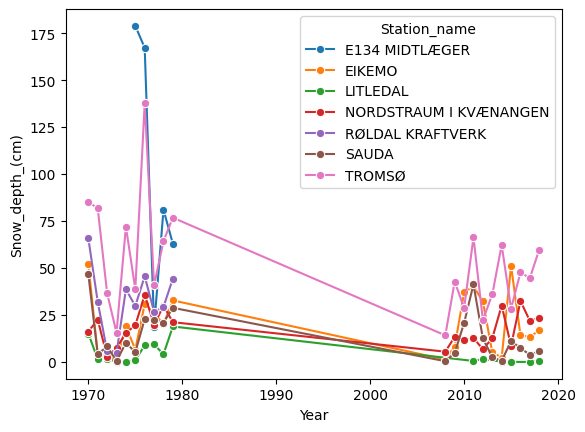

In [59]:
sns.lineplot(data=snow_jan_avg, x='Year', y='Snow_depth_(cm)', hue='Station_name', marker="o")

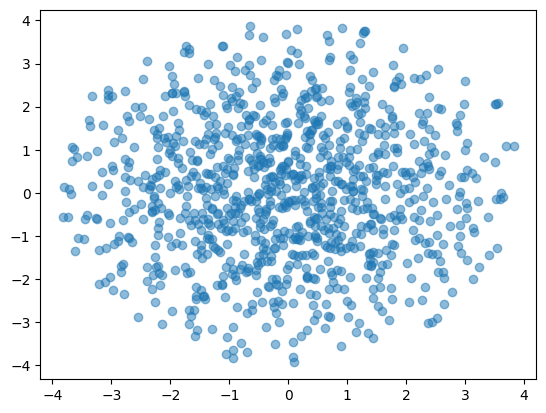

In [67]:
# sklearn tsne on multidimensional normal distribution
import numpy as np
from sklearn.manifold import TSNE
import matplotlib

# Generate a 1000x10 matrix of random numbers from a normal distribution
np.random.seed(42)
X = np.random.randn(1000, 7000)

# Fit a t-SNE model with 2 components
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)